In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from scipy import io as sio
import seaborn as sns
import matplotlib.pyplot as plt

import physipy

## Chemotaxis 96 hours experiments

In [76]:
def read_results_into_df(output_path):
    variables = ['position_y']
    all_cells = []
    replicates = list(output_path.glob('output*'))
    number_of_output_files = len(list(replicates[0].glob('output*.xml')))

    for replicate in replicates[:3]:
        for timestep in range(number_of_output_files):
            cell_data = physipy.get_cell_data(timestep, replicate, variables)
            cell_df = pd.DataFrame(cell_data)
            cell_df['day'] = timestep
            cell_df['replicate'] = replicate
            all_cells.append(cell_df)

    cells_df = pd.concat([df for df in all_cells])

    return cells_df

def read_experimental_data(experimental_conditions):
    # Store data from all conditions in a dict
    data = {}

    for condition in experimental_conditions:
        # Load file
        mat_path = DATA_PATH / f'{FILE_STEM}{condition}.mat'
        mat_file = sio.loadmat(mat_path)
        distance_to_monolayer = mat_file['glob_dist2mono']

        # Format the data from four columns to two columns
        # One column will contain the distances and the other will contain the corresponding day
        distance_to_monolayer = pd.melt(pd.DataFrame(distance_to_monolayer))
        distance_to_monolayer.rename(columns={'variable': 'day', 'value': 'distance'},
                                     inplace=True)
        # Drop the NaN rows
        distance_to_monolayer = distance_to_monolayer.dropna()
        # Convert day column from 0 index notation
        distance_to_monolayer['day'] = distance_to_monolayer['day'] + 1
        distance_to_monolayer['distance'] = distance_to_monolayer['distance']
        distance_to_monolayer['condition'] = condition

        data[condition] = distance_to_monolayer
        
    data_df = pd.concat(data)

    return data_df

def fix_distance_baseline(data_df):
    """Computes new distance values based on the predicted monolayer location"""
    
    data_df['fixed_distance'] = np.NaN

    # Select each condition and print info on minimum values
    for condition in data_df.condition.unique():
        condition_indexes = list(data_df[data_df['condition'] == condition].index)
        condition_df = data_df.loc[condition_indexes]
        minimum_values = condition_df.groupby('day')['distance'].describe()['min']
        baseline_value = minimum_values.mean()
        data_df.loc[condition_indexes, 'fixed_distance'] = \
            data_df.loc[condition_indexes, 'distance'] - baseline_value

    data_df.loc[data_df['fixed_distance'] < 0, 'fixed_distance'] = 0
    
    return data_df

FILE_STEM = 'multichip_data_'
DATA_PATH = Path('./experimental_data')

chemotaxis_conditions = ['control', 'cell_channel', 'opposite_channel']
conditions_labels = ['Control', 'Monolayer chamber', 'Opposite chamber']

chemotaxis_df = read_experimental_data(chemotaxis_conditions)
chemotaxis_df = fix_distance_baseline(chemotaxis_df)
control_df = chemotaxis_df[chemotaxis_df['condition'] == 'control'].copy()

cells = pd.read_csv('../saved_dfs/chemo96_control_df.csv')

#output = Path('../final_output/')
#cells = read_results_into_df(output)

In [37]:
chemotaxis_df.loc['cell_channel']

,day,distance,condition,fixed_distance
0,1,251.2,cell_channel,190.0
1,1,200.0,cell_channel,138.8
2,1,196.8,cell_channel,135.6
3,1,171.2,cell_channel,110.0
4,1,225.6,cell_channel,164.4
...,...,...,...,...
1639,4,179.2,cell_channel,118.0
1640,4,136.0,cell_channel,74.8
1641,4,152.0,cell_channel,90.8
1642,4,169.6,cell_channel,108.4


In [77]:
median_control = control_df[control_df['day'] == 2]['fixed_distance'].median()

cell_df = chemotaxis_df[chemotaxis_df['condition'] == 'cell_channel'].copy()
median_cell = cell_df[cell_df['day'] == 2]['fixed_distance'].median()

opposite_df = chemotaxis_df[chemotaxis_df['condition'] == 'opposite_channel'].copy()
median_opposite = opposite_df[opposite_df['day'] == 2]['fixed_distance'].median()

In [78]:
print(median_control, median_cell, median_opposite)

96.8 143.60000000000002 201.2


In [79]:
cell_increase = (median_cell-median_control)/median_control*100
cell_increase

48.34710743801656

In [80]:
opposite_increase = (median_opposite-median_control)/median_control*100
opposite_increase

107.85123966942147

In [83]:
chemotaxis_conditions = ['control_216h', 'factor_216h']

chemotaxis_df = read_experimental_data(chemotaxis_conditions)
chemotaxis_df = fix_distance_baseline(chemotaxis_df)

# Fix the times at which the information was stored
convert_days = {old: new 
                for old, new in zip(range(1, 9), [0, 1, 2, 3, 4, 7, 8, 9])}  

chemotaxis_df['day'] = chemotaxis_df['day'].map(convert_days)
control_df = chemotaxis_df[chemotaxis_df['condition'] == 'control_216h'].copy()

median_control = control_df[control_df['day'] == 9]['fixed_distance'].median()

opposite_df = chemotaxis_df[chemotaxis_df['condition'] == 'factor_216h'].copy()
median_opposite = opposite_df[opposite_df['day'] == 9]['fixed_distance'].median()

print(median_control, median_opposite)

205.6775 449.19


In [84]:
opposite_increase = (median_opposite-median_control)/median_control*100
opposite_increase

118.39530332681016

In [93]:
chemotaxis_df

day  distance    condition  fixed_distance
4mg_control 0       0    144.90  4mg_control         117.530
            1       0    180.32  4mg_control         152.950
            2       0    111.09  4mg_control          83.720
            3       0     78.89  4mg_control          51.520
            4       0     67.62  4mg_control          40.250
...               ...       ...          ...             ...
4mg_factor  3435    3    172.27   4mg_factor         140.875
            3436    3    218.96   4mg_factor         187.565
            3437    3    652.05   4mg_factor         620.655
            3438    3    635.95   4mg_factor         604.555
            3439    3    679.42   4mg_factor         648.025

[3560 rows x 4 columns]

In [96]:
chemotaxis_conditions = ['4mg_control', '4mg_factor']

chemotaxis_df = read_experimental_data(chemotaxis_conditions)
chemotaxis_df = fix_distance_baseline(chemotaxis_df)

chemotaxis_df['day'] = chemotaxis_df['day'].map(convert_days)
control_df = chemotaxis_df[chemotaxis_df['condition'] == '4mg_control'].copy()

median_control = control_df[control_df['day'] == 3]['fixed_distance'].median()

opposite_df = chemotaxis_df[chemotaxis_df['condition'] == '4mg_factor'].copy()
median_opposite = opposite_df[opposite_df['day'] == 3]['fixed_distance'].median()

print(median_control, median_opposite)

165.82999999999998 268.06500000000005


In [97]:
opposite_increase = (median_opposite-median_control)/median_control*100
opposite_increase

61.650485436893256

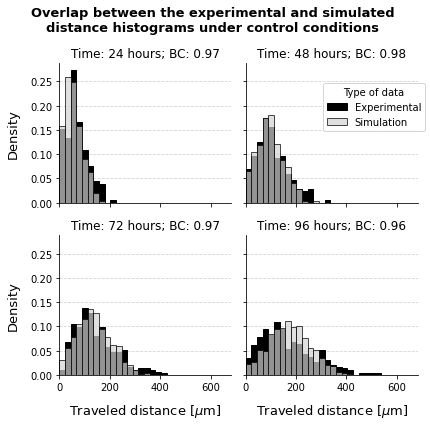

In [3]:
distance_range = 650
number_of_bins = 30
bins = np.linspace(0, distance_range, number_of_bins)

# Plot figure (each column represents a day)
fig, axes = plt.subplots(2, 2, figsize=(6, 6), sharey=True, sharex=True)
axes = axes.ravel()

for i, ax in enumerate(axes):
    distance_at_day = control_df[control_df['day'] == i+1]['fixed_distance']
    weights = np.ones_like(distance_at_day) / len(distance_at_day)
    hist_exp, *metadata = ax.hist(distance_at_day, weights=weights, bins=bins,
                                  label='Experimental' if i==0 else None,
                                  facecolor='black',
                                  edgecolor='black')
    
    distance_at_day = cells[cells['timestep'] == i+1]['position_y']
    weights = np.ones_like(distance_at_day) / len(distance_at_day)
    hist_comp, *metadata = ax.hist(distance_at_day, weights=weights, bins=bins, 
                                    label='Simulation' if i==0 else None,
                                    facecolor='lightgrey', alpha=0.7, edgecolor='black')
    
    similarity_matrix = [np.sqrt(comp_bin * exp_bin)
                             for comp_bin, exp_bin
                             in zip(hist_comp, hist_exp)]
    
    bc = np.sum(similarity_matrix)
    
    ax.set_xlim(0, None)
    ax.set_title(f'Time: {(i+1)*24} hours; BC: {round(bc, 2)}')
    if i > 1:
        ax.set_xlabel('Traveled distance [$\mu$m]', labelpad=10, fontsize=13)
    if (i == 0) | (i == 2):
        ax.set_ylabel('Density', labelpad=10, fontsize=13)
    
    ax.set_axisbelow(True)
    ax.grid(axis='y', c='lightgrey', linestyle='dashed')
    
sns.despine()

plt.suptitle('Overlap between the experimental and simulated\ndistance histograms under control conditions', 
             fontweight='bold',
             fontsize=13)

fig.tight_layout()

fig.legend(title='Type of data', loc=(0.75, 0.69))
#plt.savefig('/home/ines/writing/pdgf_paper/img/chemo96_bc.png')
#plt.savefig('/home/ines/writing/pdgf_paper/img/chemo96_bc.svg', format="svg")

In [6]:
simulation_cells = []

for i in range(3):
    cells = pd.read_csv(f'../saved_dfs/chemo216/control_{i}.csv')
    simulation_cells.append(cells)
    
final_cells = pd.concat(simulation_cells)
final_cells

,position_y,timestep,replicate
0,8.412711,0,final_output/output3
1,8.412711,0,final_output/output3
2,8.412711,0,final_output/output3
3,8.412711,0,final_output/output3
4,8.412711,0,final_output/output3
...,...,...,...
16473,469.705508,9,final_output/output2
16474,153.226402,9,final_output/output2
16475,483.315804,9,final_output/output2
16476,388.715267,9,final_output/output2


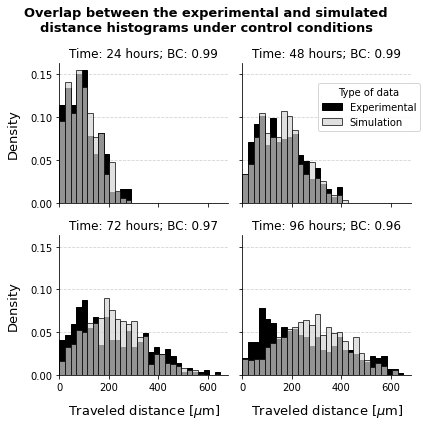

In [51]:
control_df = chemotaxis_df[chemotaxis_df['condition'] == 'cell_channel'].copy()

cells = pd.read_csv('../saved_dfs/chemo216_opposite_df.csv')

distance_range = 650
number_of_bins = 30
bins = np.linspace(0, distance_range, number_of_bins)

# Plot figure (each column represents a day)
fig, axes = plt.subplots(2, 2, figsize=(6, 6), sharey=True, sharex=True)
axes = axes.ravel()

for i, ax in enumerate(axes):
    distance_at_day = control_df[control_df['day'] == i+1]['fixed_distance']
    weights = np.ones_like(distance_at_day) / len(distance_at_day)
    hist_exp, *metadata = ax.hist(distance_at_day, weights=weights, bins=bins,
                                  label='Experimental' if i==0 else None,
                                  facecolor='black',
                                  edgecolor='black')
    
    distance_at_day = cells[cells['timestep'] == i+1]['position_y']
    weights = np.ones_like(distance_at_day) / len(distance_at_day)
    hist_comp, *metadata = ax.hist(distance_at_day, weights=weights, bins=bins, 
                                    label='Simulation' if i==0 else None,
                                    facecolor='lightgrey', alpha=0.7, edgecolor='black')
    
    similarity_matrix = [np.sqrt(comp_bin * exp_bin)
                             for comp_bin, exp_bin
                             in zip(hist_comp, hist_exp)]
    
    bc = np.sum(similarity_matrix)
    
    ax.set_xlim(0, None)
    ax.set_title(f'Time: {(i+1)*24} hours; BC: {round(bc, 2)}')
    if i > 1:
        ax.set_xlabel('Traveled distance [$\mu$m]', labelpad=10, fontsize=13)
    if (i == 0) | (i == 2):
        ax.set_ylabel('Density', labelpad=10, fontsize=13)
    
    ax.set_axisbelow(True)
    ax.grid(axis='y', c='lightgrey', linestyle='dashed')
    
sns.despine()

plt.suptitle('Overlap between the experimental and simulated\ndistance histograms under control conditions', 
             fontweight='bold',
             fontsize=13)

fig.tight_layout()

fig.legend(title='Type of data', loc=(0.75, 0.69))

In [44]:
control_df.groupby('day').count()

,distance,condition,fixed_distance
day,,,
0,127,127,127
1,260,260,260
2,437,437,437
3,569,569,569
4,571,571,571
7,749,749,749
8,793,793,793
9,749,749,749


# 216 hours

In [52]:
chemotaxis_conditions = ['control_216h', 'factor_216h']

chemotaxis_df = read_experimental_data(chemotaxis_conditions)
chemotaxis_df = fix_distance_baseline(chemotaxis_df)

# Fix the times at which the information was stored
convert_days = {old: new 
                for old, new in zip(range(1, 9), [0, 1, 2, 3, 4, 7, 8, 9])}  

chemotaxis_df['day'] = chemotaxis_df['day'].map(convert_days)
control_df = chemotaxis_df[chemotaxis_df['condition'] == 'control_216h'].copy()

In [19]:
cells = pd.read_csv('../saved_dfs/chemo216/control_test_0.csv')

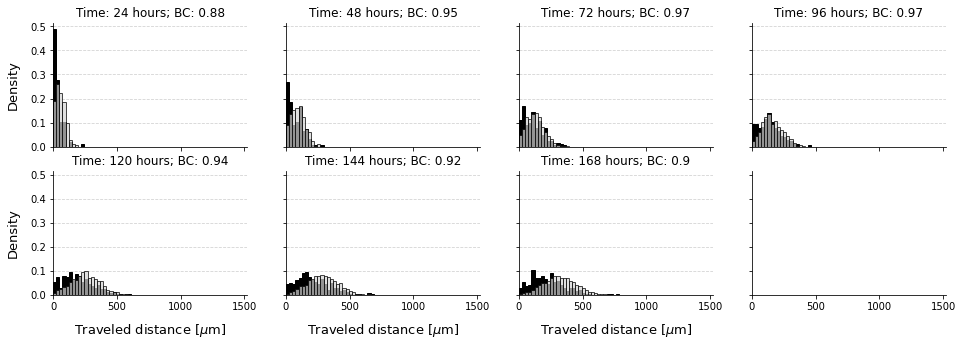

In [20]:
distance_range = 1450
number_of_bins = 60
bins = np.linspace(0, distance_range, number_of_bins)

# Plot figure (each column represents a day)
fig, axes = plt.subplots(2, 4, figsize=(16, 5), sharey=True, sharex=True)
axes = axes.ravel()
days = [1, 2, 3, 4, 7, 8, 9]

for i, ax in enumerate(axes):
    if i < 7:
        distance_at_day = control_df[control_df['day'] == days[i]]['fixed_distance']
        weights = np.ones_like(distance_at_day) / len(distance_at_day)
        hist_exp, *metadata = ax.hist(distance_at_day, weights=weights, bins=bins,
                                      label='Experimental' if i==0 else None,
                                      facecolor='black',
                                      edgecolor='black')

        distance_at_day = cells[cells['timestep'] == days[i]]['position_y']
        weights = np.ones_like(distance_at_day) / len(distance_at_day)
        hist_comp, *metadata = ax.hist(distance_at_day, weights=weights, bins=bins, 
                                        label='Simulation' if i==0 else None,
                                        facecolor='lightgrey', alpha=0.7, edgecolor='black')

        similarity_matrix = [np.sqrt(comp_bin * exp_bin)
                                 for comp_bin, exp_bin
                                 in zip(hist_comp, hist_exp)]

        bc = np.sum(similarity_matrix)

        ax.set_xlim(0, None)
        ax.set_title(f'Time: {(i+1)*24} hours; BC: {round(bc, 2)}')
        if i > 3:
            ax.set_xlabel('Traveled distance [$\mu$m]', labelpad=10, fontsize=13)
        if (i == 0) | (i == 4):
            ax.set_ylabel('Density', labelpad=10, fontsize=13)

        ax.set_axisbelow(True)
        ax.grid(axis='y', c='lightgrey', linestyle='dashed')
    
sns.despine()

In [21]:
control_df = chemotaxis_df[chemotaxis_df['condition'] == 'control_216h'].copy()


0.9272840405248961


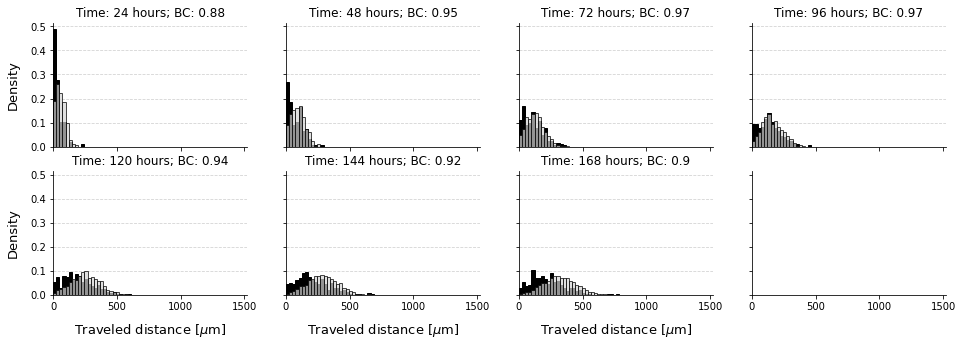

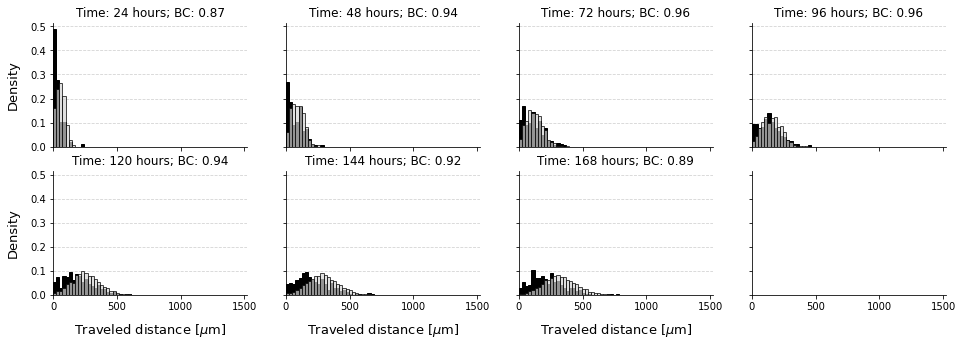

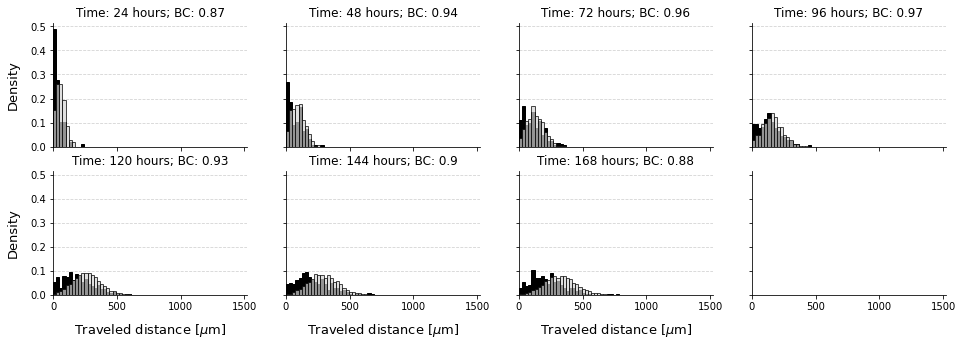

In [22]:
distance_range = 1450
number_of_bins = 60
bins = np.linspace(0, distance_range, number_of_bins)

similarity = []
for i in range(3):
    cells = pd.read_csv(f'../saved_dfs/chemo216/control_test_{i}.csv')

    # Plot figure (each column represents a day)
    fig, axes = plt.subplots(2, 4, figsize=(16, 5), sharey=True, sharex=True)
    axes = axes.ravel()
    days = [1, 2, 3, 4, 7, 8, 9]
    all_bc = []

    for i, ax in enumerate(axes):
        if i < 7:
            distance_at_day = control_df[control_df['day'] == days[i]]['fixed_distance']
            weights = np.ones_like(distance_at_day) / len(distance_at_day)
            hist_exp, *metadata = ax.hist(distance_at_day, weights=weights, bins=bins,
                                          label='Experimental' if i==0 else None,
                                          facecolor='black',
                                          edgecolor='black')

            distance_at_day = cells[cells['timestep'] == days[i]]['position_y']
            weights = np.ones_like(distance_at_day) / len(distance_at_day)
            hist_comp, *metadata = ax.hist(distance_at_day, weights=weights, bins=bins, 
                                            label='Simulation' if i==0 else None,
                                            facecolor='lightgrey', alpha=0.7, edgecolor='black')

            similarity_matrix = [np.sqrt(comp_bin * exp_bin)
                                     for comp_bin, exp_bin
                                     in zip(hist_comp, hist_exp)]

            bc = np.sum(similarity_matrix)

            ax.set_xlim(0, None)
            ax.set_title(f'Time: {(i+1)*24} hours; BC: {round(bc, 2)}')
            if i > 3:
                ax.set_xlabel('Traveled distance [$\mu$m]', labelpad=10, fontsize=13)
            if (i == 0) | (i == 4):
                ax.set_ylabel('Density', labelpad=10, fontsize=13)

            ax.set_axisbelow(True)
            ax.grid(axis='y', c='lightgrey', linestyle='dashed')
            all_bc.append(bc)
    similarity.append(np.mean(all_bc))

    sns.despine()
    
print(np.mean(similarity))

0.9589849696493479


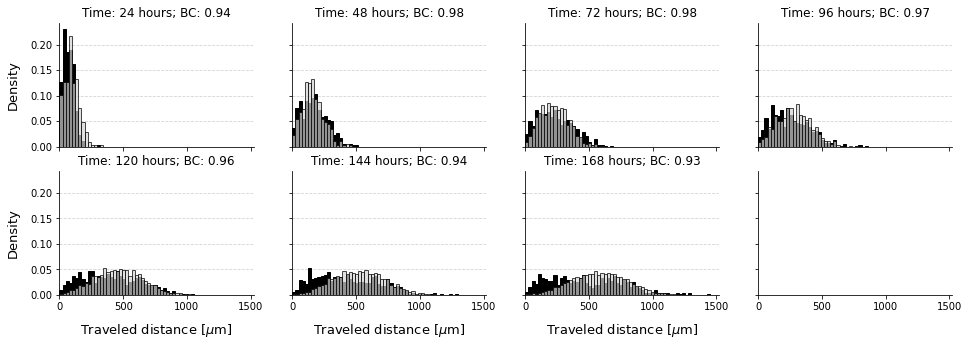

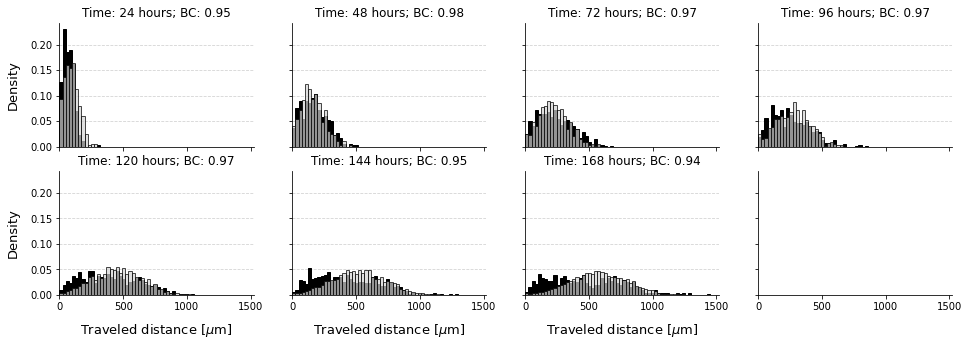

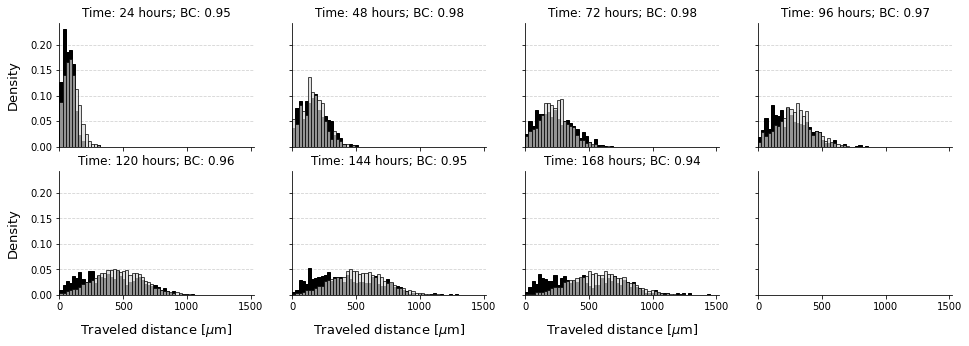

In [23]:
control_df = chemotaxis_df[chemotaxis_df['condition'] == 'factor_216h'].copy()

distance_range = 1450
number_of_bins = 60
bins = np.linspace(0, distance_range, number_of_bins)

similarity = []
for i in range(3):
    cells = pd.read_csv(f'../saved_dfs/chemo216/opposite_{i}.csv')

    # Plot figure (each column represents a day)
    fig, axes = plt.subplots(2, 4, figsize=(16, 5), sharey=True, sharex=True)
    axes = axes.ravel()
    days = [1, 2, 3, 4, 7, 8, 9]
    all_bc = []

    for i, ax in enumerate(axes):
        if i < 7:
            distance_at_day = control_df[control_df['day'] == days[i]]['fixed_distance']
            weights = np.ones_like(distance_at_day) / len(distance_at_day)
            hist_exp, *metadata = ax.hist(distance_at_day, weights=weights, bins=bins,
                                          label='Experimental' if i==0 else None,
                                          facecolor='black',
                                          edgecolor='black')

            distance_at_day = cells[cells['timestep'] == days[i]]['position_y']
            weights = np.ones_like(distance_at_day) / len(distance_at_day)
            hist_comp, *metadata = ax.hist(distance_at_day, weights=weights, bins=bins, 
                                            label='Simulation' if i==0 else None,
                                            facecolor='lightgrey', alpha=0.7, edgecolor='black')

            similarity_matrix = [np.sqrt(comp_bin * exp_bin)
                                     for comp_bin, exp_bin
                                     in zip(hist_comp, hist_exp)]

            bc = np.sum(similarity_matrix)

            ax.set_xlim(0, None)
            ax.set_title(f'Time: {(i+1)*24} hours; BC: {round(bc, 2)}')
            if i > 3:
                ax.set_xlabel('Traveled distance [$\mu$m]', labelpad=10, fontsize=13)
            if (i == 0) | (i == 4):
                ax.set_ylabel('Density', labelpad=10, fontsize=13)

            ax.set_axisbelow(True)
            ax.grid(axis='y', c='lightgrey', linestyle='dashed')
            all_bc.append(bc)
    similarity.append(np.mean(all_bc))

    sns.despine()
    
print(np.mean(similarity))

In [14]:
chemotaxis_df

day  distance     condition  fixed_distance
control_216h 0       0     78.89  control_216h         26.9675
             1       0     77.28  control_216h         25.3575
             2       0     72.45  control_216h         20.5275
             3       0     74.06  control_216h         22.1375
             4       0     75.67  control_216h         23.7475
...                ...       ...           ...             ...
factor_216h  6607    9    750.26   factor_216h        708.4000
             6608    9    375.13   factor_216h        333.2700
             6609    9    354.20   factor_216h        312.3400
             6610    9    281.75   factor_216h        239.8900
             6611    9    268.87   factor_216h        227.0100

[5760 rows x 4 columns]

In [24]:
chemotaxis_conditions = ['4mg_control', '4mg_factor']

chemotaxis_df = read_experimental_data(chemotaxis_conditions)
chemotaxis_df = fix_distance_baseline(chemotaxis_df)

control_df = chemotaxis_df[chemotaxis_df['condition'] == '4mg_control'].copy()

0.9616338911902491
0.004056900252381242


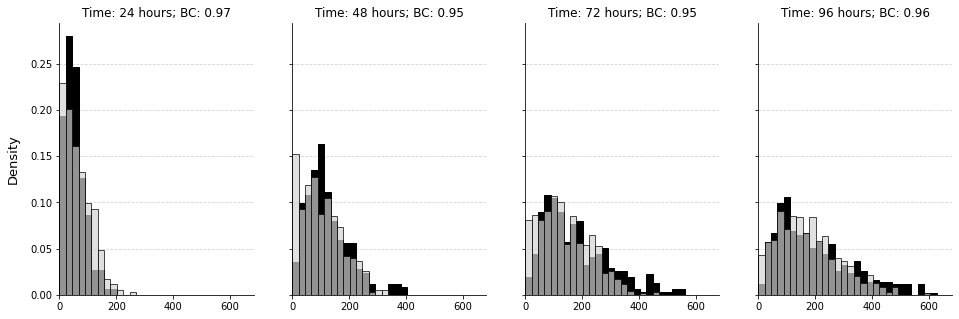

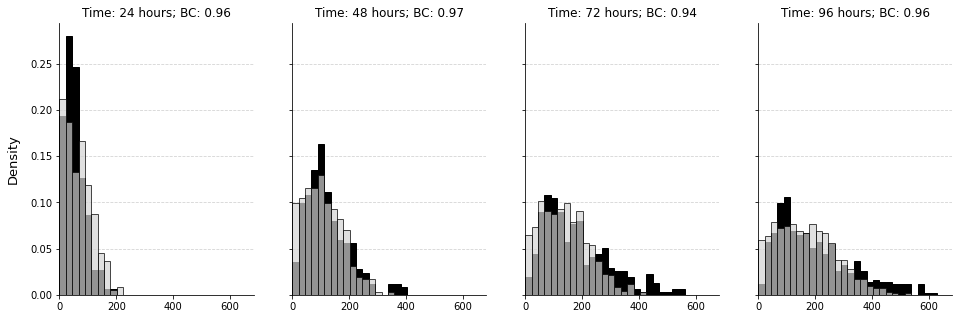

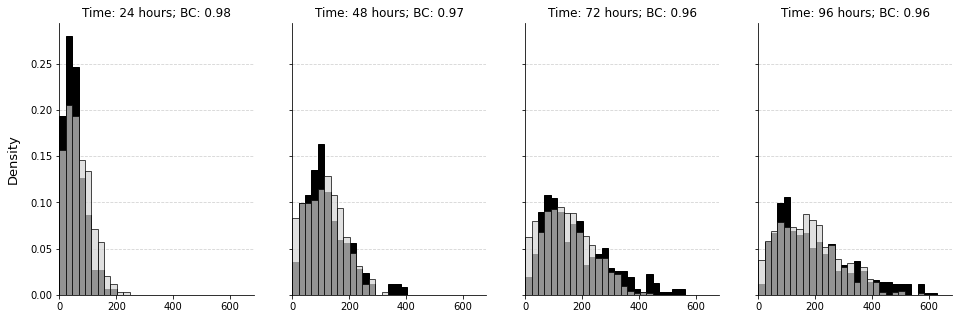

In [25]:
distance_range = 650
number_of_bins = 30
bins = np.linspace(0, distance_range, number_of_bins)

similarity = []
for i in range(3):
    cells = pd.read_csv(f'../saved_dfs/4mg/control_{i}.csv')

    # Plot figure (each column represents a day)
    fig, axes = plt.subplots(1, 4, figsize=(16, 5), sharey=True, sharex=True)
    all_bc = []

    for i, ax in enumerate(axes):
        if i < 7:
            distance_at_day = control_df[control_df['day'] == i+1]['fixed_distance']
            weights = np.ones_like(distance_at_day) / len(distance_at_day)
            hist_exp, *metadata = ax.hist(distance_at_day, weights=weights, bins=bins,
                                          label='Experimental' if i==0 else None,
                                          facecolor='black',
                                          edgecolor='black')

            distance_at_day = cells[cells['timestep'] == i+1]['position_y']
            weights = np.ones_like(distance_at_day) / len(distance_at_day)
            hist_comp, *metadata = ax.hist(distance_at_day, weights=weights, bins=bins, 
                                            label='Simulation' if i==0 else None,
                                            facecolor='lightgrey', alpha=0.7, edgecolor='black')

            similarity_matrix = [np.sqrt(comp_bin * exp_bin)
                                     for comp_bin, exp_bin
                                     in zip(hist_comp, hist_exp)]

            bc = np.sum(similarity_matrix)

            ax.set_xlim(0, None)
            ax.set_title(f'Time: {(i+1)*24} hours; BC: {round(bc, 2)}')
            if i > 3:
                ax.set_xlabel('Traveled distance [$\mu$m]', labelpad=10, fontsize=13)
            if (i == 0) | (i == 4):
                ax.set_ylabel('Density', labelpad=10, fontsize=13)

            ax.set_axisbelow(True)
            ax.grid(axis='y', c='lightgrey', linestyle='dashed')
            all_bc.append(bc)
    similarity.append(np.mean(all_bc))

    sns.despine()
    
print(np.mean(similarity))
print(np.std(similarity))

In [26]:
control_df = chemotaxis_df[chemotaxis_df['condition'] == '4mg_factor'].copy()

0.9710357413873286
0.001941466854064833


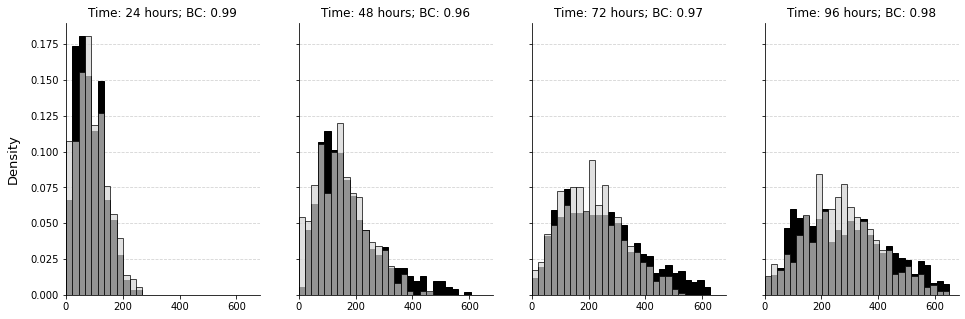

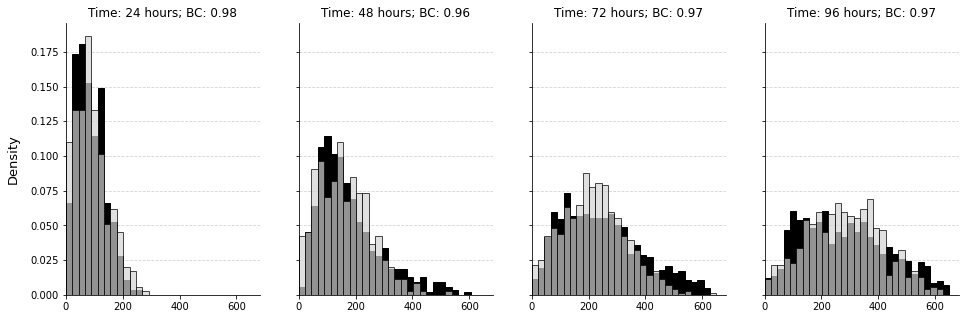

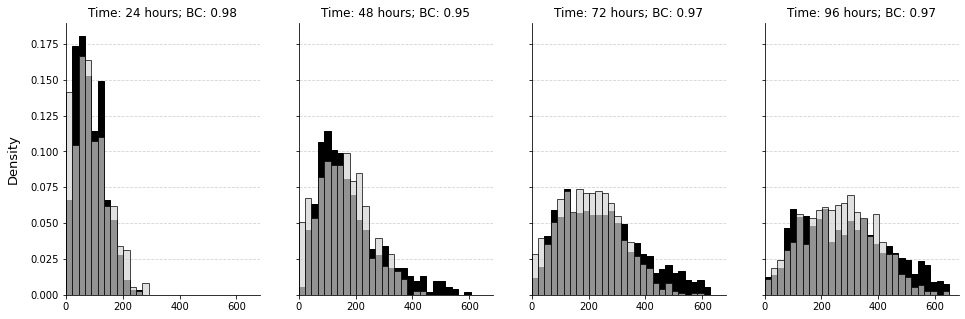

In [27]:
similarity = []
for i in range(3):
    cells = pd.read_csv(f'../saved_dfs/4mg/opposite_{i}.csv')

    # Plot figure (each column represents a day)
    fig, axes = plt.subplots(1, 4, figsize=(16, 5), sharey=True, sharex=True)
    all_bc = []

    for i, ax in enumerate(axes):
        if i < 7:
            distance_at_day = control_df[control_df['day'] == i+1]['fixed_distance']
            weights = np.ones_like(distance_at_day) / len(distance_at_day)
            hist_exp, *metadata = ax.hist(distance_at_day, weights=weights, bins=bins,
                                          label='Experimental' if i==0 else None,
                                          facecolor='black',
                                          edgecolor='black')

            distance_at_day = cells[cells['timestep'] == i+1]['position_y']
            weights = np.ones_like(distance_at_day) / len(distance_at_day)
            hist_comp, *metadata = ax.hist(distance_at_day, weights=weights, bins=bins, 
                                            label='Simulation' if i==0 else None,
                                            facecolor='lightgrey', alpha=0.7, edgecolor='black')

            similarity_matrix = [np.sqrt(comp_bin * exp_bin)
                                     for comp_bin, exp_bin
                                     in zip(hist_comp, hist_exp)]

            bc = np.sum(similarity_matrix)

            ax.set_xlim(0, None)
            ax.set_title(f'Time: {(i+1)*24} hours; BC: {round(bc, 2)}')
            if i > 3:
                ax.set_xlabel('Traveled distance [$\mu$m]', labelpad=10, fontsize=13)
            if (i == 0) | (i == 4):
                ax.set_ylabel('Density', labelpad=10, fontsize=13)

            ax.set_axisbelow(True)
            ax.grid(axis='y', c='lightgrey', linestyle='dashed')
            all_bc.append(bc)
    similarity.append(np.mean(all_bc))

    sns.despine()
    
print(np.mean(similarity))
print(np.std(similarity))

In [45]:
import plotly.graph_objects as go

In [59]:
categories = ['sigma','t_persist','r_lateral', 'r_vertical', 'b_fwd']

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=[0.47, 0.344, 0.36, 0.76, 0.56],
      theta=categories,
      fill='toself',
      name='Product A'
))
fig.add_trace(go.Scatterpolar(
      r=[0.93, 0.996, 0.36, 0.89, 0.56],
      theta=categories,
      fill='toself',
      name='Product B'
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True
    )),
  showlegend=False
)

fig.show()

In [53]:
1.4/3

0.4666666666666666